In [1]:
#Bunch of Imports
import bokeh
import bokeh.plotting as bk
import bokeh.models as bk_models
import pandas as pd
import numpy as np
import nltk
import re
import string
from pandas.io.json import json_normalize
import json
import glob
from langdetect import detect
from wordcloud import WordCloud
import gensim
import itertools as it
import matplotlib.pyplot as plt
from gensim.models.wrappers import FastText
FAST_TEXT_MODEL_FILE='/Users/suppu17/Desktop/1/wiki.en/wiki.en'

/anaconda/lib/python2.7/site-packages/cryptography/hazmat/primitives/constant_time.py:26: CryptographyDeprecationWarning: Support for your Python version is deprecated. The next version of cryptography will remove support. Please upgrade to a 2.7.x release that supports hmac.compare_digest as soon as possible.
  utils.DeprecatedIn23,


# Functions to Read Data, process and remove Duplicates

In [2]:
#Regex init
url_regex = re.compile(
        r'^(?:http|ftp)s?://' # http:// or https://
        r'(?:(?:[A-Z0-9](?:[A-Z0-9-]{0,61}[A-Z0-9])?\.)+(?:[A-Z]{2,6}\.?|[A-Z0-9-]{2,}\.?)|' #domain...
        r'localhost|' #localhost...
        r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})' # ...or ip
        r'(?::\d+)?' # optional port
        r'(?:/?|[/?]\S+)$', re.IGNORECASE)
tokenizer = nltk.tokenize.TweetTokenizer()
lemmatizer = nltk.WordNetLemmatizer()
stopwords = set(nltk.corpus.stopwords.words('english'))
printable_chars = set(string.printable)
punctuations = set(string.punctuation)

In [3]:
'''
from langdetect.detector_factory import DetectorFactory
factory = DetectorFactory()
factory.load_profile('/Users/apple/Desktop/swisher/analysis/langdetect/profiles/')

def detect_lang(text):
    detector = factory.create()
    detector.append(text)
    return detector.detect()
'''

"\nfrom langdetect.detector_factory import DetectorFactory\nfactory = DetectorFactory()\nfactory.load_profile('/Users/apple/Desktop/swisher/analysis/langdetect/profiles/')\n\ndef detect_lang(text):\n    detector = factory.create()\n    detector.append(text)\n    return detector.detect()\n"

In [4]:
def filter_non_english_tweets(df):
    accepted_langs = ['en', 'et', 'ro', 'ca', 'sw', 'fi', 'sk', 'so', 'id', 'fr','pl', 'sv', 'hr', 'sl', 'tl', 'it', 'cy', 'sq', 'cs', 'hu']
    lang_list = []
    lang = ""
    for i in list(df['text']):
        try:
            lang = detect(i) 
            lang = "Not accepted" if lang not in accepted_langs else lang
        except Exception as e:
            pass
        lang_list.append(lang)
    df['lang'] = lang_list
    #df = df[df['lang'] != False]
    return df

In [5]:
def lemmatizeToken(token, tag):
        tag = {
            'N': nltk.corpus.wordnet.NOUN,
            'V': nltk.corpus.wordnet.VERB,
            'R': nltk.corpus.wordnet.ADV,
            'J': nltk.corpus.wordnet.ADJ
        }.get(tag[0], nltk.corpus.wordnet.NOUN)
        print tag,"lol"
        return lemmatizer.lemmatize(token, tag)
    
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

In [6]:
def normalize_tweet(tweet,lemmatize=True):
    words = []
    clean_tweet = ''.join(filter(lambda c: c in printable_chars, tweet))
    for token, tag in nltk.pos_tag(tokenizer.tokenize(clean_tweet.lower())):
        if len(token) < 2 or url_regex.search(token):
            continue
        elif all(char in punctuations for char in token):
            continue
        elif token[0] == '@':
            token = '@person' #Replace all friend tags with a common token.
            tag = 'NNP'
        words.append(lemmatize_text(token)[0] if lemmatize else str(token))
    return words

In [7]:
def read_data(file_name):
    '''
        Read the data and convert createdAt to timestamp
        Drop cols=id, createdAt, latitude, longitude, place_country, place_name, place_type
    '''
    header = pd.read_csv(file_name, nrows=0)
    df = pd.read_csv(file_name,usecols=header)
    df['timestamp'] = pd.to_datetime(df['createdAt'],errors='coerce')
    
    df = df[df.isRetweet == '0']
    
    df = df.drop(['createdAt','isRetweet','latitude','longitude', 'place_country', 'place_name', 'place_type'],axis=1)
    df['id']=pd.to_numeric(df['id'], errors='coerce')
    df.dropna(subset=['id'],inplace=True)
    df['NormalizedText'] = list(map(normalize_tweet, df['text']))
    df = filter_non_english_tweets(df)
    return df

# Process the data and save

In [ ]:
file_list = glob.glob("data/*.csv") #location of tweets
print file_list
for fname in file_list:
    print "Processing:  ",fname,
    df = read_data(fname)
    #print df.head()
    print "Processed:  ",fname, "*** Count: ",len(df)
    df.to_csv('unique_tweets/'+fname.split('/')[-1], index=False)

# Read cleaned and unique dataset

In [8]:
data_df = pd.DataFrame()
file_list = glob.glob("unique_tweets/*.csv")
for fname in file_list:
    temp = pd.read_csv(fname)
    data_df = data_df.append(temp)
    

In [9]:
len(data_df)

111263

In [10]:
df = data_df[~data_df['lang'].isnull()] #remove non english tweets
df = df[df['lang']!='Not accepted']

In [11]:
print "Total Unique Tweets",len(data_df)
print "Length of english tweets",len(df)

Total Unique Tweets 111263
Length of english tweets 107762


In [12]:
unique_userid = df['userId'].unique()
len(unique_userid)

76043

In [ ]:
#save the list of user ids
with open('user_id.csv', 'w') as f:
    for id in unique_userid:
        f.write("%s\n" % id)

In [ ]:
df.to_csv("unique_english_data.csv",index=False)

# Add grams to Data frame

In [13]:
df = pd.read_csv("unique_english_data.csv")

In [14]:
df.head()

id                                               text  \
0  1.057890e+18  Social platforms operate with sloppy disregard...   
1  1.057891e+18  Social platforms operate with sloppy disregard...   
2  1.057891e+18  Social platforms operate with sloppy disregard...   
3  1.057891e+18  #ICanRelate\n#MustLoveCats\n\nTony Swisher htt...   
4  1.057892e+18  Social platforms operate with sloppy disregard...   

       userId            timestamp  \
0    19757554  2018-11-01 00:01:07   
1    27365543  2018-11-01 00:02:58   
2  2985579963  2018-11-01 00:04:03   
3    27611383  2018-11-01 00:04:36   
4  3309380118  2018-11-01 00:06:19   

                                      NormalizedText lang  
0  ['social', 'platforms', 'operate', 'with', 'sl...   en  
1  ['social', 'platforms', 'operate', 'with', 'sl...   en  
2  ['social', 'platforms', 'operate', 'with', 'sl...   en  
3  ['#icanrelate', '#mustlovecats', 'tony', 'swis...   en  
4  ['social', 'platforms', 'operate', 'with', 'sl...   en

# Compute Bot scores for users

In [15]:
bot_df = pd.DataFrame()
file_list = glob.glob("processed/*.json")
count = 0
user_id = []
universal_score=[]
english_score = []
for fname in file_list:
    data = []
    with open(fname) as f:
        for line in f:
            d = json_normalize(json.loads(line))
            if 'user.id_str' in d:
                user_id.append(d['user.id_str'][0])
                universal_score.append(d['scores.universal'][0])
                english_score.append(d['scores.english'][0])
            else:
                pass

In [16]:
bot_df['user_id']= user_id
bot_df['universal_score']=universal_score
bot_df['english_score'] = english_score

In [17]:
bot_df.head()

user_id  universal_score  english_score
0            778131066         0.041107       0.021562
1  1026221825829814278         0.336555       0.269102
2            569105186         0.128516       0.079455
3            227149083         0.056245       0.032660
4           2448604032         0.070893       0.073433

In [ ]:
len(bot_df)
bot_df.to_csv('bot_results.csv',index=False)

# Filter data from bots

In [18]:
bot_df= pd.read_csv('bot_results.csv')

In [19]:
bot_threshold = 0.8

In [20]:
bot_df = bot_df[bot_df['english_score']<=bot_threshold]

In [21]:
len(bot_df)

68712

In [22]:
df_non_bots = df[df['userId'].isin(bot_df['user_id'])]

In [23]:
len(df_non_bots)

94411

In [ ]:
df_non_bots.to_csv('data_non_bots.csv',index=False)

# Filter out outliers like Kara swisher, nick and young swisher

In [24]:
df = pd.read_csv("data_non_bots.csv")

In [25]:
print len(df)

89490


In [26]:
df = df[~df['text'].str.contains('kara swisher',case=False)]

In [27]:
print "after removing Kara swisher",len(df)

after removing Kara swisher 84953


In [28]:
df = df[~df['text'].str.contains('nick swisher',case=False)]
print "after removing nick swisher",len(df)

after removing nick swisher 81612


In [29]:
df = df[~df['text'].str.contains('young swisher',case=False)]
print "after removing young swisher",len(df)

after removing young swisher 81333


# Use Fast Text

In [30]:
def process_fast_text(tweet_df,ft_model):
    url_regex = re.compile(
        r'^(?:http|ftp)s?://' # http:// or https://
        r'(?:(?:[A-Z0-9](?:[A-Z0-9-]{0,61}[A-Z0-9])?\.)+(?:[A-Z]{2,6}\.?|[A-Z0-9-]{2,}\.?)|' #domain...
        r'localhost|' #localhost...
        r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})' # ...or ip
        r'(?::\d+)?' # optional port
        r'(?:/?|[/?]\S+)$', re.IGNORECASE)
    tokenizer = nltk.tokenize.TweetTokenizer()
    lemmatizer = nltk.WordNetLemmatizer()
    stopwords = set(nltk.corpus.stopwords.words('english'))
    printable_chars = set(string.printable)
    punctuations = set(string.punctuation)
    tweet_df['NormalizedText'] = list(map(normalize_tweet, tweet_df.text))
    # Load the word vectors for the tweets 1-grams
    onegram_df = pd.DataFrame(list(nltk.FreqDist(it.chain(*tweet_df.NormalizedText)).items()),
                 columns=['Word', 'Freq'])
    onegram_df['Tweets'] = onegram_df.Word.apply(lambda word: set())
    onegram_df['TweetsCount'] = onegram_df.Word.apply(lambda word: 0)
    onegram_df['IsInteresting'] = onegram_df.Word.apply(lambda word: word not in stopwords and not word.strip().isdigit())
    
    print onegram_df.head()
    
    print('Loading FastText model. Will take a few minutes...')
    #ft_model = FastText.load_fasttext_format(FAST_TEXT_MODEL_FILE)
    #print('FastText model loaded.')
    onegram_df['Vector'] = list(map(lambda x: ft_model[x] if x in ft_model else np.zeros(300), onegram_df.Word))
    onegram_df.set_index('Word', inplace=True)
    onegram_df.sort_values(['Freq'], ascending=[False], inplace=True)
    for i, tweet in enumerate(tweet_df.NormalizedText):
        for word in tweet:
            onegram_df.loc[word].Tweets.add(i)
            onegram_df.at[word, 'TweetsCount'] = len(onegram_df.loc[word].Tweets)        
    
    #onegram_df.to_csv("data_onegram.csv")
    
    # Load the bam histogram
    print('Processing bi-grams')
    bigram_df = pd.DataFrame(list(nltk.FreqDist(it.chain(*map(lambda x: map('-'.join,
                        filter(lambda bi: all(word not in stopwords and not word.strip().isdigit() for word in bi),
                               nltk.bigrams(x))), tweet_df.NormalizedText))).items()),
                columns=['Word', 'Freq'])
    bigram_df['Tweets'] = bigram_df.Word.apply(lambda word: set())
    bigram_df['TweetsCount'] = bigram_df.Word.apply(lambda word: 0)
    bigram_df.set_index('Word', inplace=True)
    bigram_df.sort_values(['Freq'], ascending=[False], inplace=True)
    for i, tweet in enumerate(tweet_df.NormalizedText):
        for bigram in filter(lambda bi: all(word not in stopwords and not word.strip().isdigit() for word in bi), nltk.bigrams(tweet)):        
            key = '-'.join(bigram)
            bigram_df.loc[key].Tweets.add(i)
            bigram_df.at[key, 'TweetsCount'] = len(bigram_df.loc[key].Tweets)

    #bigram_df.to_csv("data_bigram.csv")
    #tweet_df.to_csv("tweet_df.csv")
    return tweet_df, onegram_df, bigram_df

In [31]:
print('Loading FastText model. Will take a few minutes...')
ft_model = FastText.load_fasttext_format(FAST_TEXT_MODEL_FILE)
print('FastText model loaded.')

Loading FastText model. Will take a few minutes...
FastText model loaded.


In [32]:
tweet_df = process_fast_text(df,ft_model)

             Word  Freq Tweets  TweetsCount  IsInteresting
0   yanks-indians     1     {}            0           True
1            fawk     1     {}            0           True
2  #rabbitsmokers     1     {}            0           True
3           woods     2     {}            0           True
4         hanging    42     {}            0           True
Loading FastText model. Will take a few minutes...
Processing bi-grams


# Word Cloud

In [33]:
def create_wordcloud(freqDict,fname, w=800, h=600):
    wc = WordCloud(width=w, height=h).generate_from_frequencies(freqDict)
    plt.figure(figsize=(30,30))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.savefig(fname, bbox_inches = 'tight',pad_inches = 0.1, dpi=200)
    plt.show()

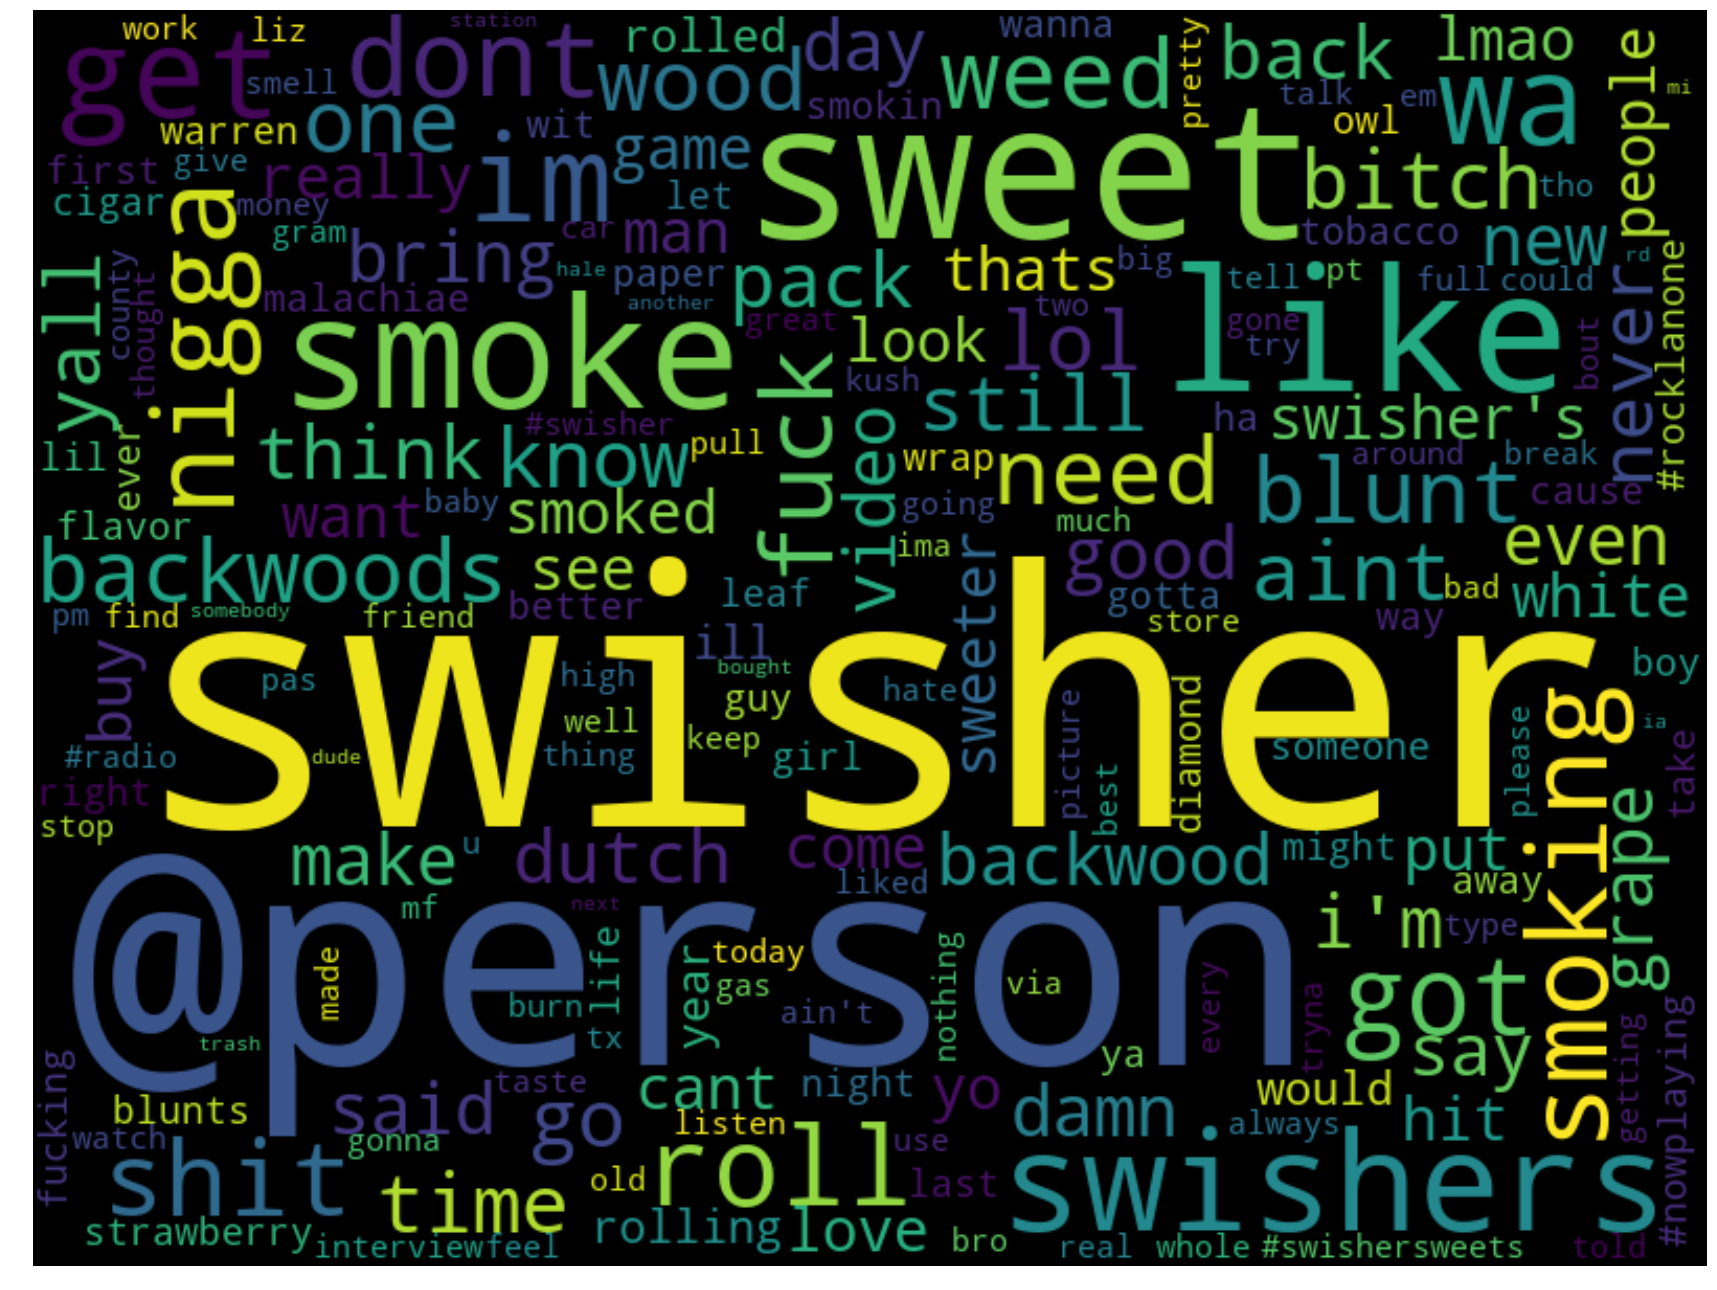

In [34]:
create_wordcloud(tweet_df[1][tweet_df[1].IsInteresting].to_dict()['Freq'],fname='onegram_wordcloud.png')

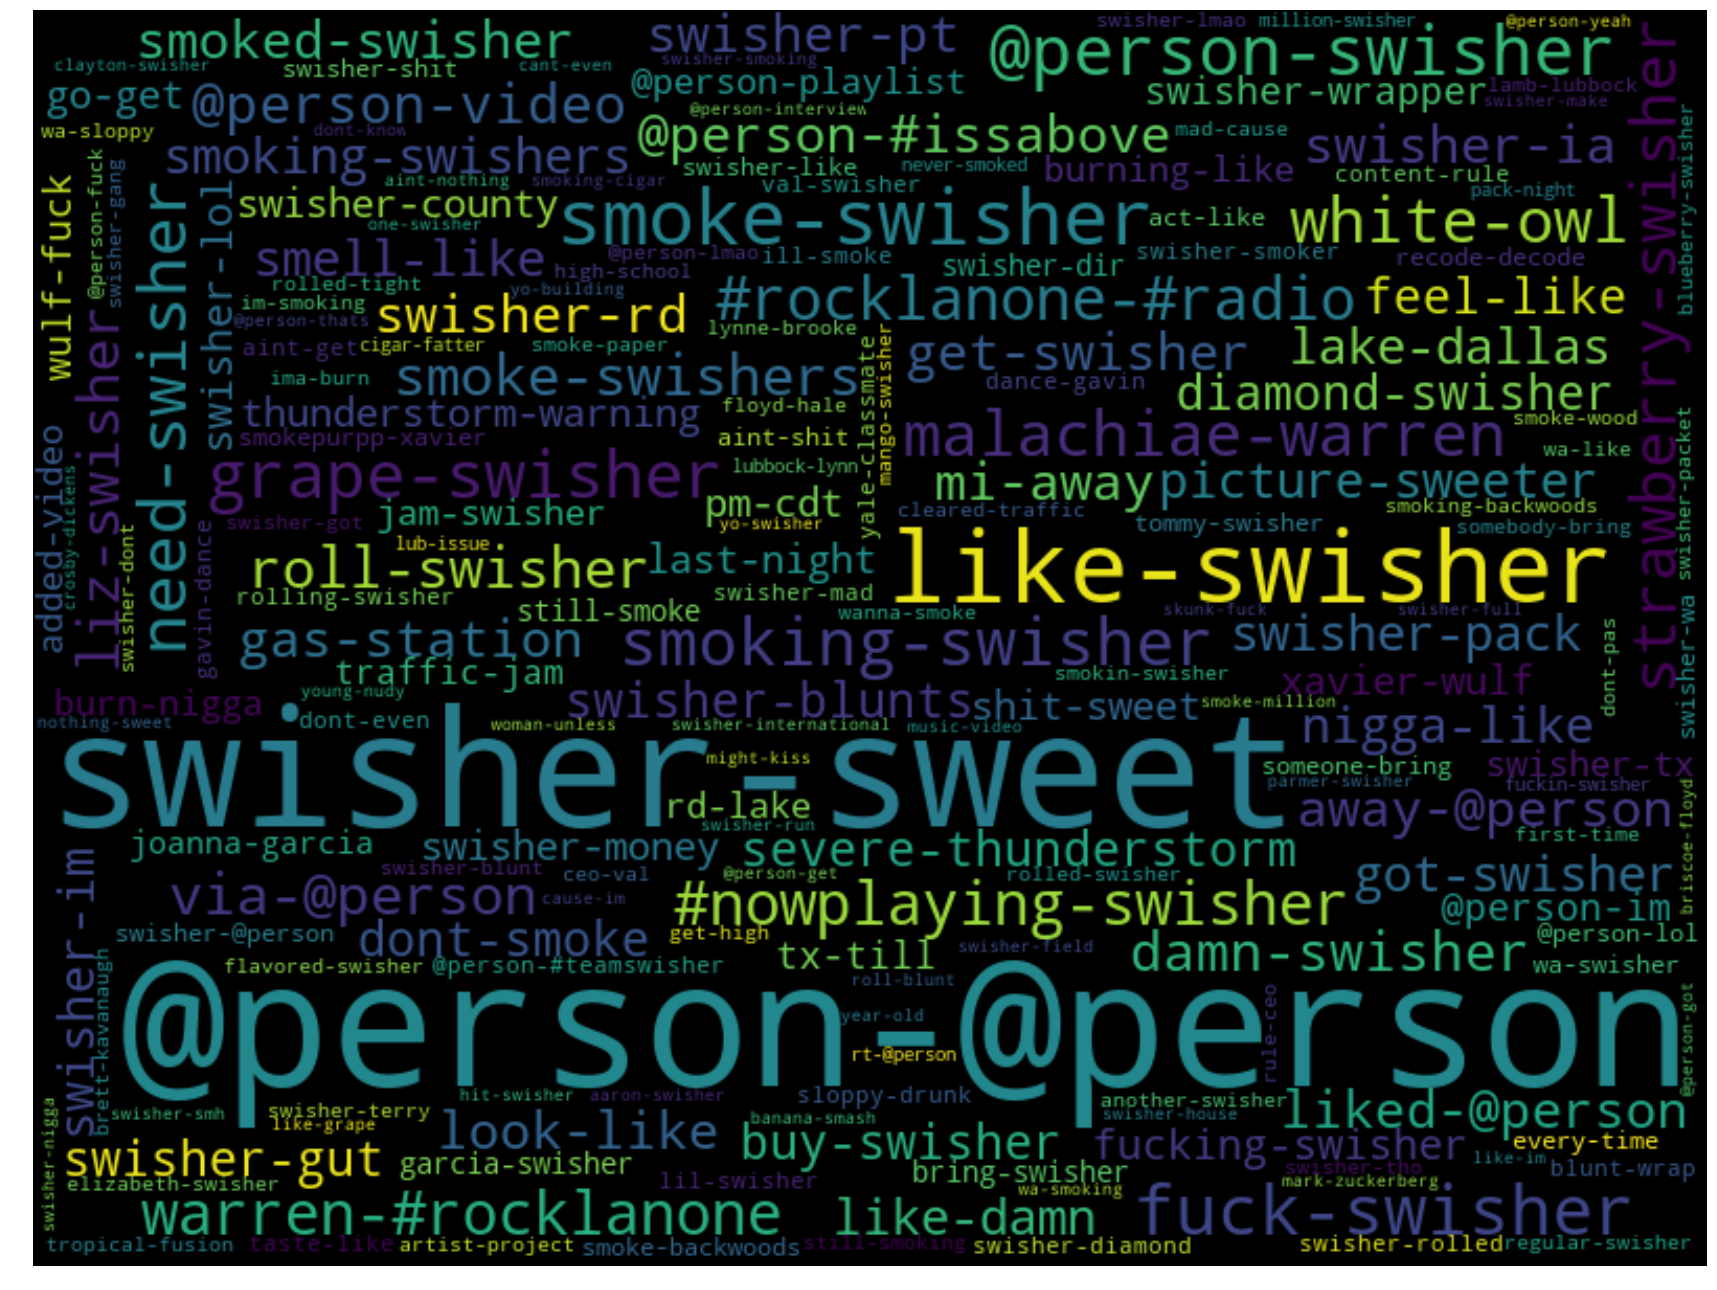

In [35]:
create_wordcloud(tweet_df[2].to_dict()['Freq'],fname = 'bigram_wordcloud.png')

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


            Word  Freq Tweets  TweetsCount  IsInteresting
0  yanks-indians     1     {}            0           True
1        hanging    13     {}            0           True
2         nallen     1     {}            0           True
3          woodz     2     {}            0           True
4      localized     1     {}            0           True
Loading FastText model. Will take a few minutes...
Processing bi-grams


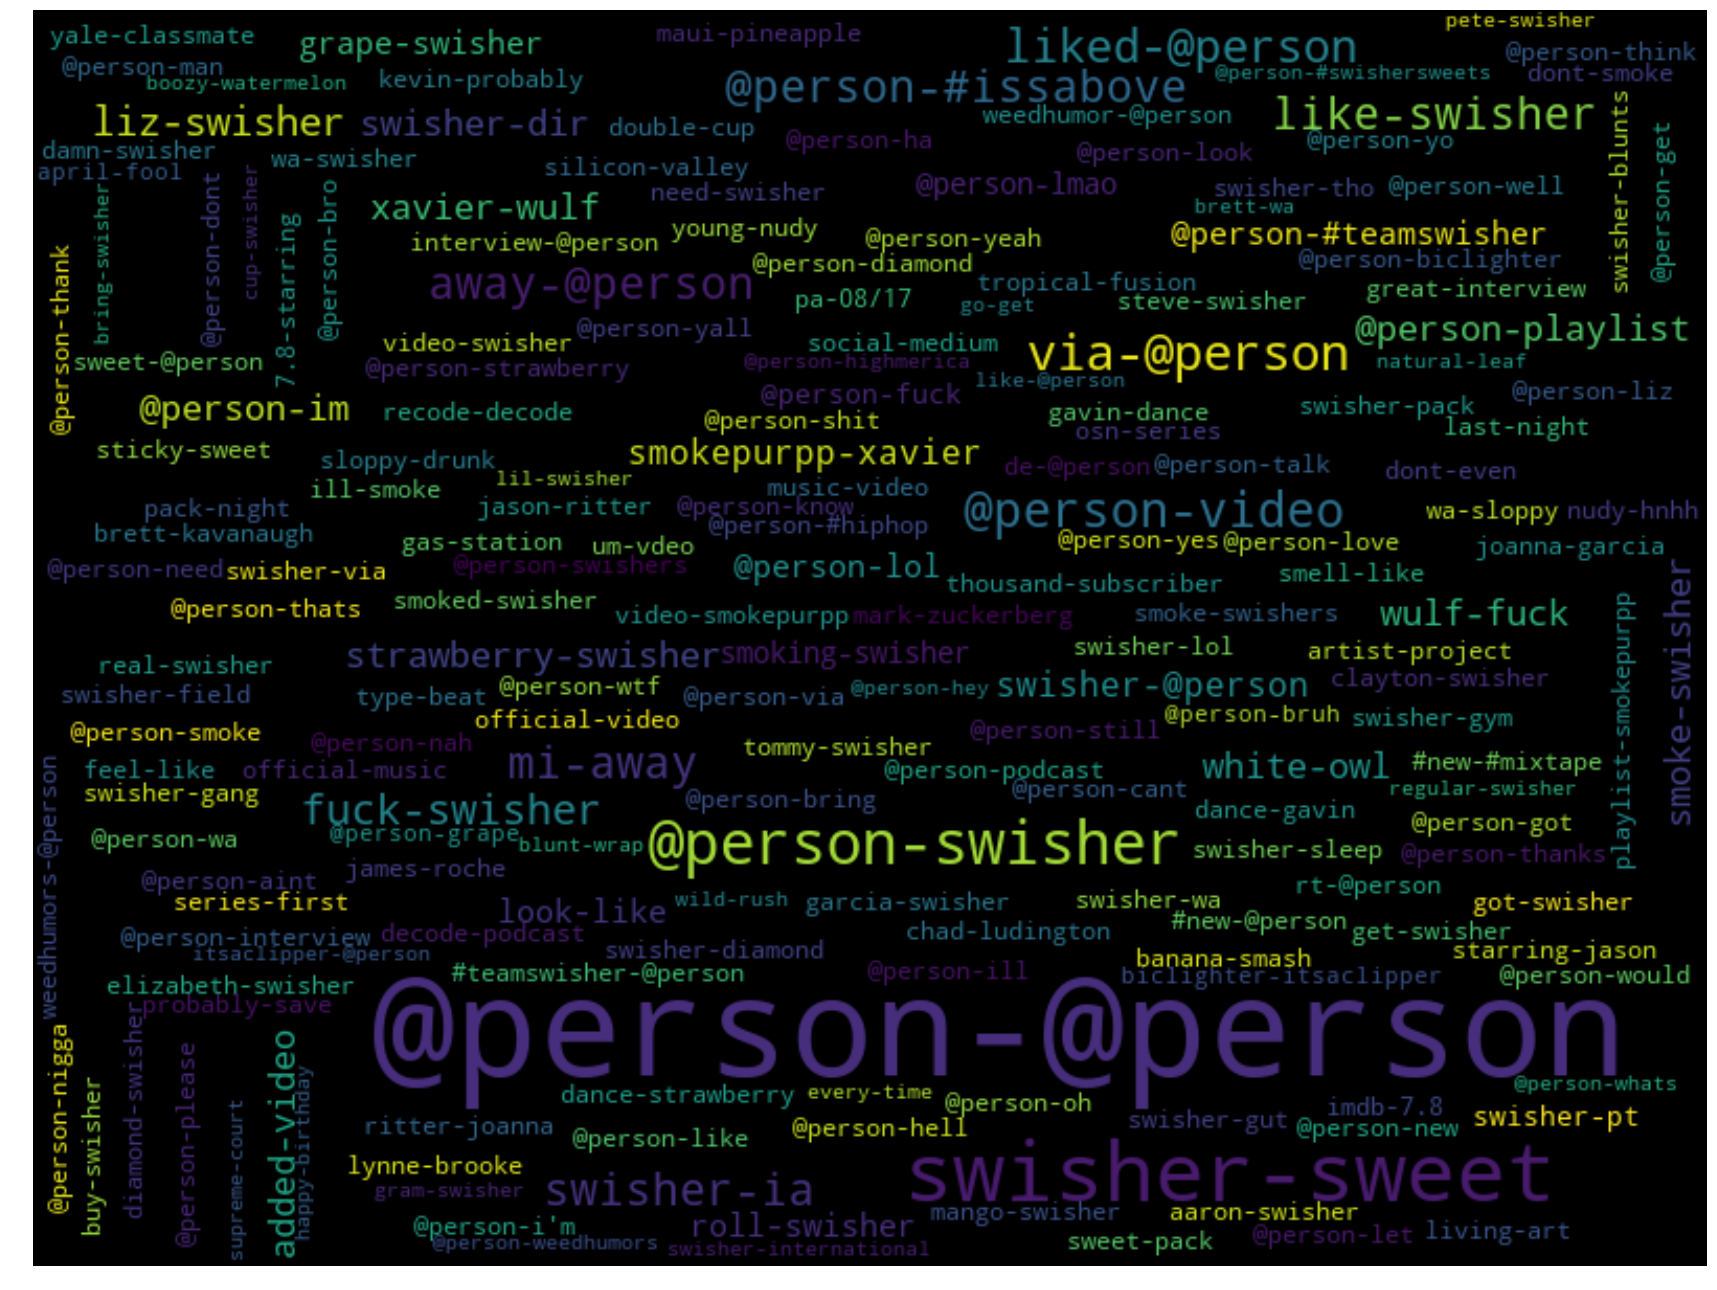

In [36]:
#Wordcloud of @person tagged tweets
wc_df=df[df['text'].str.contains('@',case=False)]
wc_person = process_fast_text(wc_df,ft_model)
create_wordcloud(wc_person[2].to_dict()['Freq'],fname = 'bigram_wordcount_person_tags.png')

In [37]:
tweet_df[2].reset_index()[['Word','Freq']].head(10)#.to_csv("bigram_count.csv")

Word   Freq
0  @person-@person  12564
1    swisher-sweet  10422
2     like-swisher   2473
3    smoke-swisher   1351
4  @person-swisher   1076
5     fuck-swisher   1058
6    grape-swisher   1022
7     need-swisher   1010
8  smoking-swisher    969
9        white-owl    895

In [ ]:
#IDentified topics


# Confusion Matrix for the 8 topics

In [38]:
def retrain_vectors(data, epochs=5):
    model = gensim.models.Word2Vec(data[0].NormalizedText, size=300, min_count=1)
    for row in data[1][data[1].IsInteresting].itertuples():
        if row.Index not in model.wv.vocab:
            data[1].at[row.Index, 'IsInteresting'] = False
        else:
            model.wv.syn0[model.wv.vocab[row.Index].index] = row.Vector
    model.train(data[0].NormalizedText, total_examples=model.corpus_count, epochs=epochs)
    data[1]['OldVector'] = data[1].Vector
    for row in data[1][data[1].IsInteresting].itertuples():
        data[1].at[row.Index, 'Vector'] = model[row.Index]
    return model

word2vec = retrain_vectors(tweet_df)

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  import sys
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [39]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

def get_class_statistics(tweets, ngrams, class_name):
    max_ngram_length = max(len(ngram) for ngram in ngrams)
    matching_tweets = tweets[tweets.NormalizedText.apply(lambda ls: any(ngram in ngrams for ngram in it.chain(ls, *(nltk.ngrams(ls, i) for i in range(2, max_ngram_length + 1)))))]
    total_tweets_from_users = tweets[tweets.userId.isin(matching_tweets.userId.unique())]
    num_tweets = matching_tweets.shape[0]
    num_total_tweets = tweets.shape[0]
    print('Number of tweets in %s class: %d (%f%%)' % (class_name, num_tweets, num_tweets / float(num_total_tweets) * 100))
    num_users = matching_tweets.userId.unique().shape[0]
    num_total_users = tweets.userId.unique().shape[0]
    print('Number of users contributing to %s class: %d (%f%%)' % (class_name, num_users, num_users / float(num_total_users) * 100))
    num_user_tweets = total_tweets_from_users.shape[0]
    print('Total number of tweets associated with these users: %d (%f%%)' % (num_user_tweets, num_user_tweets / float(num_total_tweets) * 100))
    return class_name, matching_tweets, total_tweets_from_users

In [40]:
flavour_ngrams = {'grape','strawberry','diamond','peach','flavored','flavor','flavoured','mango','pineapple','pumpkin',
                'food-flavored','blueberry','coconut','chocolate','#pineapple','banana-strawberry','sweetscoconut',
                'pineapples','banana-pineapple','#blueberrycoconut','tropical', 'wine', 'cherry', 
                 'sweet', 'white grape','black','flavoring','watermelon','#blueberryswisher','#blueberry','vanilla-flavored',
                 'juicy fruit','banana-pineapple','flavors','mint','cinnamon','guava','grape','apple','fruit','organe','candy',
                 'caramel'}
flavour_class = get_class_statistics(tweet_df[0], flavour_ngrams, 'Flavor')

Number of tweets in Flavor class: 17049 (20.961971%)
Number of users contributing to Flavor class: 13926 (24.077596%)
Total number of tweets associated with these users: 22708 (27.919787%)


In [41]:
ngrams = {'@person'}
person_class = get_class_statistics(tweet_df[0], ngrams, 'Person tagging')


Number of tweets in Person tagging class: 26656 (32.773905%)
Number of users contributing to Person tagging class: 19866 (34.347661%)
Total number of tweets associated with these users: 32184 (39.570654%)


In [42]:
highlight_words={('smoke', 'swisher'), ('swisher', 'sweet'), ('smoking', 'swisher'),('swisher','pack'),('bring','swisher'),('still','smoke'),('someone','bring'),
'pass','hit','puff','smoke','used'}
pd.DataFrame({word: [x[0] for x in word2vec.most_similar(word, topn=10)] for word in highlight_words})

hit       pass      puff    smoke      used (bring, swisher)  \
0  hitting    passing    puff'n     roll       use             come   
1     roll     passed     fluff  smoking     tried            smoke   
2    smoke         yd    puffed      buy    wanted         swishers   
3   rolled       yard     puffe      use    trying              get   
4      pas  touchdown    fluffy     fuck       had              try   
5      get       kick     puffy   smokin     using             pull   
6      got    rushing       wax      lol     meant              put   
7      run     rushed     dough   smoked  actually               me   
8       go     kellen      cake  rolling  supposed             wood   
9    match    fumbled  powdered      hit     going             hand   

  (smoke, swisher) (smoking, swisher) (someone, bring) (still, smoke)  \
0         swishers           swishers         somebody        smoking   
1             roll              smoke             come            lol   
2               it                lol               me         really   
3              lol            rolling             pull      backwoods   
4          smoking                 it            match           wood   
5              you             smokin              try            you   
6             wood               that              ask       swishers   
7             fuck                you             grab           fuck   
8             know               just             hand           know   
9         backwood             really              buy           roll   

  (swisher, pack) (swisher, sweet)  
0        swishers         swishers  
1             box               it  
2             one        swisher's  
3            them              you  
4             and              and  
5            just             just  
6              me              one  
7              it               me  
8             you            grape  
9            some             that

In [43]:
swisher_use = {('smoke', 'swisher'), ('swisher', 'sweet'), ('smoking', 'swisher'),('swisher','pack'),('smoked','swisher'),
               ('bring','swisher'),('still','smoke'),('someone','bring'),
               ('pass','swisher'),('passing','swisher'),('passed','swisher'),
               ('hit','swisher'),('hitting','swisher'),
               ('puff','swisher'),('puffed','swisher'),('used','swisher'),
               ('roll','swisher'),('rolled','swisher'),
              ('try','swisher'),('trying','swisher')}
swisher_use_class = get_class_statistics(tweet_df[0], swisher_use, 'Swisher use')

Number of tweets in Swisher use class: 14182 (17.436957%)
Number of users contributing to Swisher use class: 11631 (20.109617%)
Total number of tweets associated with these users: 18732 (23.031242%)


In [44]:
highlight_words={'buy',('buy','swisher')}
pd.DataFrame({word: [x[0] for x in word2vec.most_similar(word, topn=10)] for word in highlight_words})

buy (buy, swisher)
0    sell            get
1  bought       swishers
2  buying          smoke
3     get         bought
4   smoke           just
5     pay            you
6    grab           roll
7     use             me
8   store            and
9    find            one

In [45]:
promotional_ngrams = {'buy',('swishers','buy'),('buy','swisher'),('buying','swisher'),('bought','swisher'),('grab','swisher'),
                     ('pay','swisher')}

promotional_class = get_class_statistics(tweet_df[0], promotional_ngrams, 'Purchases')

Number of tweets in Purchases class: 1542 (1.895909%)
Number of users contributing to Purchases class: 1456 (2.517376%)
Total number of tweets associated with these users: 3007 (3.697146%)


In [46]:
highlight_words={('need','swisher'),('like','swisher'),('get','swisher'),('got','swisher'),('go','get'),
                ('crave','swisher'),('enjoy','swisher'),('everyday','swisher'),('like','swisher'),
                 ('love','swisher'),('want','swisher')}
pd.DataFrame({word: [x[0] for x in word2vec.most_similar(word, topn=10)] for word in highlight_words})

crave      enjoy   everyday       get     go        got      like  \
     swisher    swisher    swisher   swisher    get    swisher   swisher   
0   swishers   swishers  swisher's  swishers    buy   swishers        it   
1  swisher's  swisher's   swishers        it   come        get  swishers   
2        eat        get     really       and   grab        put       and   
3      enjoy         it       them      just   find        and      that   
4     sticky        you        you       you   take      bitch      just   
5    craving      smoke    fucking       lol    hit  swisher's       lol   
6   backwood     really      still       got    see        lol      know   
7      savor      blunt       that     smoke   went        had       you   
8     tasted       shit  literally        me   need       that      said   
9       sour        lol         me       buy  smoke         my     blunt   

        love       need       want  
     swisher    swisher    swisher  
0    @person       want   swishers  
1   swishers   swishers       need  
2        and        got  swisher's  
3         it         it      wanna  
4  swisher's  swisher's      smoke  
5       that        get         do  
6        one        put         me  
7      smoke      smoke       know  
8        you       just         it  
9         my        and        you

In [47]:
appeal_ngrams = {('need','swisher'),('need','swishers'),('like','swisher'),('like','swishers'),
                 ('get','swisher'),('got','swisher'),('go','get'),
                ('crave','swisher'),('crave','swishers'),('enjoy','swisher'),
                 ('everyday','swisher'),('like','swisher'),
                 ('love','swisher'), ('love','swishers'),('want','swisher'),('want','swishers'),
                 ('cool','swisher'),('cool','swishers')}
appeal_class = get_class_statistics(tweet_df[0], appeal_ngrams, 'Appeal')

Number of tweets in Appeal class: 4817 (5.922565%)
Number of users contributing to Appeal class: 4329 (7.484699%)
Total number of tweets associated with these users: 7447 (9.156185%)


In [48]:
anti_ngrams = {('dont','smoke'),('no','smoke')}
anti_class = get_class_statistics(tweet_df[0], anti_ngrams, 'Anti')

Number of tweets in Anti class: 355 (0.436477%)
Number of users contributing to Anti class: 352 (0.608596%)
Total number of tweets associated with these users: 536 (0.659019%)


In [49]:
highlight_words={('roll','swisher'),('swisher','blunts'),('swisher','gut'),('rolling','swisher'),('swisher','rolled'),('blunt','wrap')}

pd.DataFrame({word: [x[0] for x in word2vec.most_similar(word, topn=10)] for word in highlight_words})

blunt      roll   rolling    swisher                    
        wrap   swisher   swisher     blunts       gut    rolled
0      paper     smoke  swishers   swishers       car      roll
1       wood  swishers   smoking      blunt  swishers   rolling
2        lol        it      roll       wood        it        it
3     blunts    rolled     smoke  backwoods      just  swishers
4   swishers   rolling    rolled  swisher's      weed    smoked
5  backwoods       you    rollin   backwood       mid     smoke
6   backwood      wood        it      sweet     grape       lol
7       hemp  backwood  backwood         it       and     blunt
8       weed       put      shit        lol     sweet   smoking
9    fucking        me      wood        you   wrapper      shit

In [50]:
cannabis_ngrams = {('roll','swisher'),('roll','swishers'),('rolling','swishers'),('rolling','swisher'),('rolled','swishers'),('rolled','swisher'),
                   ('swisher','blunts'),('swishers','blunt'),('swisher','blunt'),('swisher','gut'),('swishers','gut'),('swisher','rolled'),('blunt','wrap'),'marijuana','weed'}
cannabis_class = get_class_statistics(tweet_df[0], cannabis_ngrams, 'Cannabis use')

Number of tweets in Cannabis use class: 5088 (6.255763%)
Number of users contributing to Cannabis use class: 4671 (8.076005%)
Total number of tweets associated with these users: 7835 (9.633236%)


In [51]:
highlight_words={('white','owl'),('smoke','backwoods'),'cigar'}
pd.DataFrame({word: [x[0] for x in word2vec.most_similar(word, topn=10)] for word in highlight_words})

cigar (smoke, backwoods) (white, owl)
0  cigarillo               wood        dutch
1  cigarette           backwood    backwoods
2    tobacco                lol         wood
3  backwoods           swishers        paper
4   flavored              paper        black
5     blunts              dutch         game
6       wrap               roll      diamond
7      those            smoking      regular
8     flavor               fuck         leaf
9   swishers            regular     swishers

In [52]:
cigar_ngrams = {('white','owl'),('smoke','backwoods'),('smoking','backwoods'),('smoke','backwood'),('smoking','backwood')}
cigar_class = get_class_statistics(tweet_df[0], cigar_ngrams, 'Cigar comparison')

Number of tweets in Cigar comparison class: 1332 (1.637712%)
Number of users contributing to Cigar comparison class: 1283 (2.218265%)
Total number of tweets associated with these users: 2101 (2.583207%)


In [53]:
highlight_words={('fuck','swisher'),('damn','swisher'),('fucking','swisher'),('aint','swisher'),
                  ('swisher','shit'),('dont','smoke'),('no','smoke'),('shit','swisher')}
pd.DataFrame({word: [x[0] for x in word2vec.most_similar(word, topn=10)] for word in highlight_words})

aint      damn     dont       fuck   fucking         no       shit  \
    swisher   swisher    smoke    swisher   swisher      smoke    swisher   
0  swishers  swishers    don't   swishers  swishers       even   swishers   
1       ain   fucking      lol      smoke       lol       roll         it   
2     ain't       lol     roll       wood        me    smoking       wood   
3      dont      shit     fuck  swisher's      damn        lol      bitch   
4      wood      wood  smoking        lol      shit   swishers      nigga   
5        it        it      ion         it      just       fuck        lol   
6     nigga      just       do       shit    really       wood        you   
7      shit  backwood     damn        you     blunt  backwoods  swisher's   
8       you     bitch     wood   backwood      them         do   backwood   
9     bitch       you      you       them        it     really       them   

     swisher  
        shit  
0   swishers  
1         it  
2       wood  
3      bitch  
4      nigga  
5        lol  
6        you  
7  swisher's  
8   backwood  
9       them

In [54]:
dislike_ngrams = {('fuck','swisher'),('fuck','swishers'),('fuckin','swishers'),('shit','swisher'),('shit','swishers'),
                  ('damn','swisher'),('damn','swishers'),('fucking','swisher'),('aint','swisher'),('aint','swishers'),
                  ('swisher','shit'),('swishers','shit'),('dont','smoke'),('dont','swishers'),('dont','swisher'),
                  ("don't",'smoke'),('no','smoke'),('no','smoking')}
dislike_class = get_class_statistics(tweet_df[0], dislike_ngrams, 'Dislike')

Number of tweets in Dislike class: 2869 (3.527473%)
Number of users contributing to Dislike class: 2709 (4.683772%)
Total number of tweets associated with these users: 4192 (5.154119%)


In [55]:
ngrams={'grape','strawberry','diamond','peach','flavored','flavor','flavoured','mango','pineapple','pumpkin',
                'food-flavored','blueberry','coconut','chocolate','#pineapple','banana-strawberry','sweetscoconut',
                'pineapples','banana-pineapple','#blueberrycoconut','tropical', 'wine', 'cherry', 
                 'sweet', 'white grape','black','flavoring','watermelon','#blueberryswisher','#blueberry','vanilla-flavored',
                 'juicy fruit','banana-pineapple','flavors','mint','cinnamon','guava','grape','apple','fruit','organe','candy',
                 'caramel',
       
       '@person',
       
       ('smoke', 'swisher'), ('swisher', 'sweet'), ('smoking', 'swisher'),('swisher','pack'),('smoked','swisher'),
               ('bring','swisher'),('still','smoke'),('someone','bring'),
               ('pass','swisher'),('passing','swisher'),('passed','swisher'),
               ('hit','swisher'),('hitting','swisher'),
               ('puff','swisher'),('puffed','swisher'),('used','swisher'),
               ('roll','swisher'),('rolled','swisher'),
              ('try','swisher'),('trying','swisher'),
       
        'buy',('buy','swisher'),('buying','swisher'),('bought','swisher'),('grab','swisher'),
                     ('pay','swisher'),
        

        ('need','swisher'),('need','swishers'),('like','swisher'),('like','swishers'),
                 ('get','swisher'),('got','swisher'),('go','get'),
                ('crave','swisher'),('crave','swishers'),('enjoy','swisher'),
                 ('everyday','swisher'),('like','swisher'),
                 ('love','swisher'), ('love','swishers'),('want','swisher'),('want','swishers'),
                 ('cool','swisher'),('cool','swishers'),
        ('fuck','swisher'),('fuck','swishers'),('fuckin','swishers'),('shit','swisher'),('shit','swishers'),
                  ('damn','swisher'),('damn','swishers'),('fucking','swisher'),('aint','swisher'),('aint','swishers'),
                  ('swisher','shit'),('swishers','shit'),('dont','smoke'),('dont','swishers'),('dont','swisher'),
                  ("don't",'smoke'),('no','smoke'),('no','smoking'),
        ('roll','swisher'),('roll','swishers'),('rolling','swishers'),('rolling','swisher'),('rolled','swishers'),('rolled','swisher'),
                   ('swisher','blunts'),('swishers','blunt'),('swisher','blunt'),('swisher','gut'),('swishers','gut'),('swisher','rolled'),('blunt','wrap'),
        'marijuana','weed',('white','owl'),('smoke','backwoods'),('smoking','backwoods'),('smoke','backwood'),('smoking','backwood')
       }

_class=get_class_statistics(tweet_df[0], ngrams, 'All')

Number of tweets in All class: 51200 (62.951078%)
Number of users contributing to All class: 38970 (67.377848%)
Total number of tweets associated with these users: 57833 (71.106439%)


In [56]:
from IPython.core.display import display, HTML
def get_confusion_matrix(tweets, classes):
    num_classes = len(classes)
    tweet_matrix = []
    user_matrix = []
    total_num_tweets = float(tweets.shape[0])
    total_num_users = float(tweets.userId.unique().shape[0])
    total_tweets_repr = set()
    total_users_repr = set()
    total_user_tweet_repr = set()
    for i in range(0, num_classes):
        #print classes[i][0]
        total_tweets_repr |= set(classes[i][1].id)
        
        total_users_repr |= set(classes[i][1].userId)
        total_user_tweet_repr |= set(classes[i][2].id)
        tweet_matrix.append([])
        user_matrix.append([])
        for j in range(0, num_classes):
            num_tweet_intersection = len(np.intersect1d(classes[i][1].id, classes[j][1].id))
            tweet_matrix[i].append((num_tweet_intersection, num_tweet_intersection / total_num_tweets * 100))
            num_user_intersection = len(np.intersect1d(classes[i][1].userId.unique(), classes[j][1].userId.unique()))
            user_matrix[i].append((num_user_intersection, num_user_intersection / total_num_users * 100))
    
    return tweet_matrix, user_matrix, len(total_tweets_repr), len(total_users_repr), len(total_user_tweet_repr), total_num_tweets, total_num_users

table_template = """
<table class="table table-striped table-bordered table-condensed" style="width: 100%%">
   <caption style="font-weight: 900">%s</caption>
   <colgroup>
      <col style="width: 20%%">
      %s
   </colgroup>
   <thead>
      <tr style="vertical-align: bottom">%s</tr>
   </thead>
   <tfoot>
      <tr style="font-weight: 900"><td colspan="3">%s</td></tr>
   </tfoot>
   <tbody>%s</tbody>
</table>
"""

def display_confusion_matrix(tweets, classes):
    tweet_matrix, user_matrix, total_tweets_repr, total_users_repr, total_user_tweets_repr, total_tweets, total_users = get_confusion_matrix(tweets, classes)
    num_classes = len(classes)
    matrices = [tweet_matrix, user_matrix]
    headings = ['Number of tweets confusion matrix', 'Numer of users confusion matrix']
    footers = ['Total number of tweets: (%d) \ (%0.2f%%)' % (total_tweets_repr, total_tweets_repr / total_tweets * 100),\
              'Total number of users: (%d) \ (%0.2f%%)<br>Total number of tweets from users: (%d) \ (%0.2f%%)' % (total_users_repr,\
                                                                                                                  total_users_repr / total_users * 100,\
                                                                                                                 total_user_tweets_repr,\
                                                                                                                 total_user_tweets_repr / total_tweets * 100)]
    for k in range(2):
        matrix = matrices[k]
        col_width = ['<col style="width: %0.2f%%">' % (100.0 / num_classes)] * num_classes
        class_names = ['<th>(Number) / (% of total) </th>']
        table_rows = []
        for i in range(0, num_classes):
            #class_names.append('<th>%s</th>' % classes[i][0])
            cells = ['<th>%s</th>' % classes[i][0]]
            for j in range(0, i+1):
                cells.append('<td>(%s) / (%0.2f%%)</td>' % matrix[i][j])
            table_rows.append('<tr>%s</tr>' % ''.join(cells))
        
        table_rows.append('<th></th>')
        for i in range(0, num_classes):   
            table_rows.append('<th>%s</th>' % classes[i][0])
        display(HTML(table_template % (headings[k], ''.join(col_width), ''.join(class_names), footers[k], ''.join(table_rows))))
    
    remaining = tweets
    for cls in classes:
        mask = remaining.id.isin(cls[1].id)
        remaining = remaining[~mask]
    return remaining
    #return SimpleNamespace(tweets=remaining)

remaining_class = display_confusion_matrix(tweet_df[0], sorted([flavour_class, person_class, swisher_use_class, promotional_class,appeal_class,cannabis_class,cigar_class,dislike_class],
                                                                          key=lambda x: x[1].shape[0], reverse=True))